In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Coal Power Plant Data

In [42]:
import pandas as pd

# Read coal type data
coal_type = pd.read_csv("../data/other/coal-type.csv")

# Read 2012 coal emissions data
coal_2012 = pd.read_csv("../data/annual_emissions/annual-emissions-2012-coal.csv")

# Merge with coal type data
coal_2012 = pd.merge(coal_2012, coal_type, how="left")

coal_2012 = coal_2012.rename(columns = {'State': 'state',
 'Facility Name': 'name',
 'Facility ID': 'id',
 'Heat Input (mmBtu)': 'heatInput',
 'Gross Load (MWh)': 'grossLoad',
 'Steam Load (1000 lb)': 'steamLoad',
 'SO2 Mass (short tons)': 'so2Mass',
 'CO2 Mass (short tons)': 'co2Mass',
 'NOx Mass (short tons)': 'noxMass',
 'Fuel Type': 'coalType',
 'Energy': 'energy',
 'Year': 'year',
})

# Select relevant columns and convert units
coal_2012 = coal_2012[['state', 'name', 'id', 'year', 'heatInput', 'grossLoad', 'steamLoad', 'so2Mass',
                       'co2Mass', 'noxMass',  'coalType', 'energy']]

coal_2012['steamInd'] = (~coal_2012['steamLoad'].isna()) & (coal_2012['grossLoad'].isna())
coal_2012['energyConvert'] = coal_2012.apply(lambda x: x['energy'] if x['steamInd'] and not pd.isna(x['energy']) else (9845 if x['steamInd'] and pd.isna(x['energy']) else pd.NA), axis=1)
coal_2012['heatInput'] = coal_2012['heatInput'] * 10**6
coal_2012['grossLoad'] = coal_2012['grossLoad'] * 10**3
coal_2012['steamLoad'] = coal_2012['steamLoad'] * 1000 * 1/24 * coal_2012['energyConvert'] * 0.000293
coal_2012['load'] = coal_2012.apply(lambda x: x['steamLoad'] if pd.isna(x['grossLoad']) else x['grossLoad'], axis=1)
coal_2012['co2Mass'] = coal_2012['co2Mass'] * 0.907185 * 1000
coal_2012['so2Mass'] = coal_2012['so2Mass'] * 0.907185 * 1000
coal_2012['noxMass'] = coal_2012['noxMass'] * 0.907185 * 1000
coal_2012['heatRate'] = coal_2012['heatInput'] / coal_2012['load']
coal_2012['co2Rate'] = coal_2012['co2Mass'] / coal_2012['load']

coal_2012 = coal_2012[['state', 'name', 'id', 'heatRate', 'co2Rate']]
coal_2012 = coal_2012.dropna(subset=['heatRate', 'co2Rate'])

In [43]:
# Read 2022 coal emissions data
coal_2022 = pd.read_csv("../data/annual_emissions/annual-emissions-2022-coal.csv")

# Merge with coal type data
coal_2022 = pd.merge(coal_2022, coal_type, how="left")

coal_2022 = coal_2022.rename(columns = {'State': 'state',
 'Facility Name': 'name',
 'Facility ID': 'id',
 'Heat Input (mmBtu)': 'heatInput',
 'Gross Load (MWh)': 'grossLoad',
 'Steam Load (1000 lb)': 'steamLoad',
 'SO2 Mass (short tons)': 'so2Mass',
 'CO2 Mass (short tons)': 'co2Mass',
 'NOx Mass (short tons)': 'noxMass',
 'Fuel Type': 'coalType',
 'Energy': 'energy',
 'Year': 'year',
})

# Select relevant columns and convert units
coal_2022 = coal_2022[['state', 'name', 'id', 'year', 'heatInput', 'grossLoad', 'steamLoad', 'so2Mass',
                       'co2Mass', 'noxMass',  'coalType', 'energy']]

coal_2022['steamInd'] = (~coal_2022['steamLoad'].isna()) & (coal_2022['grossLoad'].isna())
coal_2022['energyConvert'] = coal_2022.apply(lambda x: x['energy'] if x['steamInd'] and not pd.isna(x['energy']) else (9845 if x['steamInd'] and pd.isna(x['energy']) else pd.NA), axis=1)
coal_2022['heatInput'] = coal_2022['heatInput'] * 10**6
coal_2022['grossLoad'] = coal_2022['grossLoad'] * 10**3
coal_2022['steamLoad'] = coal_2022['steamLoad'] * 1000 * 1/24 * coal_2022['energyConvert'] * 0.000293
coal_2022['load'] = coal_2022.apply(lambda x: x['steamLoad'] if pd.isna(x['grossLoad']) else x['grossLoad'], axis=1)
coal_2022['co2Mass'] = coal_2022['co2Mass'] * 0.907185 * 1000
coal_2022['so2Mass'] = coal_2022['so2Mass'] * 0.907185 * 1000
coal_2022['noxMass'] = coal_2022['noxMass'] * 0.907185 * 1000
coal_2022['heatRate'] = coal_2022['heatInput'] / coal_2022['load']
coal_2022['co2Rate'] = coal_2022['co2Mass'] / coal_2022['load']
coal_2022 = coal_2022.dropna(subset=['heatRate', 'co2Rate'])

# Combine the data
coal = pd.merge(coal_2012, coal_2022, on='id', suffixes=('2012', '2022'))

In [44]:
# Clean up
del coal_2012, coal_2022, coal_type

In [45]:
# Read ripe for retirement full data
rfr_full = pd.read_csv("../data/ripe_for_retirement/ripe-for-retirement-with-facility-id-high.csv")
rfr_full = rfr_full[['state', 'id']].assign(rfrFull=1).dropna(subset=['id'])

# Read ripe for retirement short data
rfr_short = pd.read_csv("../data/ripe_for_retirement/ripe-for-retirement-with-facility-id-low.csv")
rfr_short = rfr_short[['state', 'id']].assign(rfrShort=1).dropna(subset=['id'])

# Merge ripe for retirement data
rfr = pd.merge(rfr_full, rfr_short, on='id', how='left')

# Merge coal and ripe for retirement data
data = pd.merge(coal, rfr, on='id', how='left')

# Calculate retired indicator
data['retiredInd'] = data['heatRate2022'].isna() & data['co2Rate2022'].isna()

# Fill missing values and calculate retirement status
data['rfrFull'].fillna(0, inplace=True)
data['rfrShort'].fillna(0, inplace=True)
dataRfr = data[data['rfrFull'] == 1]
dataRfr['retired'] = dataRfr['retiredInd'].apply(lambda x: "Retired" if x else "Active")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


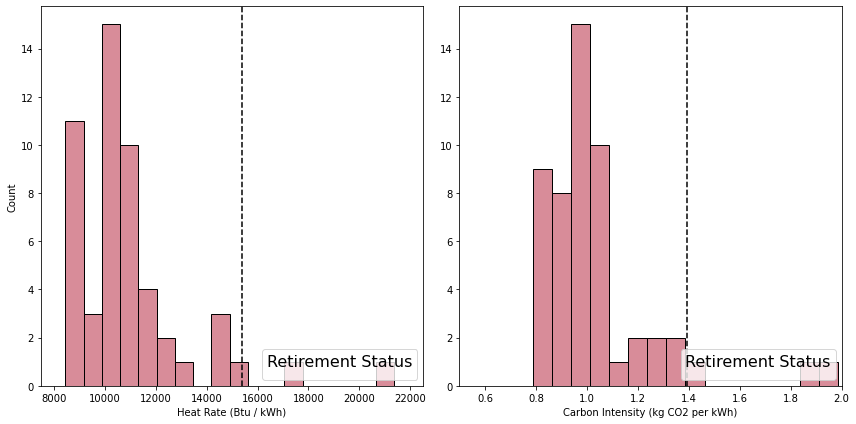

In [50]:
# Plotting
colors = {"Retired": "#CC6677", "Active": "#44AA99", "Scrubgrass": "#117733"}

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(dataRfr, x='heatRate2012', hue='retired', multiple='stack', palette=colors.values())
plt.axvline(x=15374.51, linestyle='--', color='k')
plt.xlabel("Heat Rate (Btu / kWh)")
plt.ylabel("Count")
plt.xlim(7500, 22500)
plt.legend(title="Retirement Status", loc="lower right", fontsize=12, title_fontsize=16)

plt.subplot(1, 2, 2)
sns.histplot(dataRfr, x='co2Rate2012', hue='retired', multiple='stack', palette=colors.values())
plt.axvline(x=1.393182, linestyle='--', color='k')
plt.xlabel("Carbon Intensity (kg CO2 per kWh)")
plt.ylabel("")
plt.xlim(0.5, 2)
plt.legend(title="Retirement Status", loc="lower right", fontsize=12, title_fontsize=16)

plt.tight_layout()
plt.savefig("../output/04_ripe_for_retirement04_rfr_distribution.png", dpi=300)
plt.show()